In [1]:
#Libraries
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import random
from torchvision import models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

In [2]:
from FC_NN_Architecture import *
# Dataset Loader File
from DF_DataLoader import initDataset, toDataset

In [3]:
# Data visualization of NN
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange

In [4]:
import scipy.io
from matplotlib import cm
import matplotlib
from matplotlib.ticker import MaxNLocator

# Get brain

In [5]:
mask = 700
raw_data_path = "Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/rS_slice5.mat"
raw_data = scipy.io.loadmat(raw_data_path)
raw_signals = raw_data["slice_oi"]
raw_masking_idxs = raw_signals[:,:,0] > mask
raw_ND_signals = raw_signals[raw_masking_idxs]
raw_norm = raw_ND_signals/raw_ND_signals[:,0][:,None]
display(raw_norm.shape)

(15543, 32)

In [6]:
truth_path = "Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/m41_dataStruct_slice5.mat"
truth_data = scipy.io.loadmat(truth_path)

slice_c1 = truth_data['slice']["MWF"][0,0]
reshaped_c1 = slice_c1[:,:, np.newaxis]
reshaped_c1[~raw_masking_idxs] = reshaped_c1.min()

reshaped_t21 = truth_data['slice']['T2s'][0,0][:,:, np.newaxis]
reshaped_t21[~raw_masking_idxs] = reshaped_t21.min()

reshaped_t22 = truth_data['slice']['T2l'][0,0][:,:, np.newaxis]
reshaped_t22[~raw_masking_idxs] = reshaped_t22.min()

In [7]:
path_NLLS = "Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/NLLS_3PE_with_offset_Rician.feather"
# c1_BOUNDED_Offsets_Brain_NLLS_32Pts_ExperimentalData_ostart02_preproc.feather"
df_NLLS = pd.read_feather(path_NLLS)
df_NLLS["Index"] = df_NLLS["Index"].astype(int)
df_NLLS.set_index("Index", inplace = True, drop = True)
df_NLLS.sort_index(inplace = True)
df_NLLS.head(5)

,Offset,c1_NLLS,t21_NLLS,t22_NLLS,c1_t,t21_t,t22_t,ND
Index,,,,,,,,
0,0.069216,2.301121e-03,54.107381,54.109051,0.500000,56.915970,93.915901,"[1.0, 0.8691709844559585, 0.7240932642487047, ..."
1,0.049513,9.110656e-07,54.968974,54.988965,0.000017,59.999981,72.483391,"[1.0, 0.8606658446362515, 0.7151664611590629, ..."
2,0.044243,9.846923e-11,52.759524,55.335857,0.072589,59.999466,72.680641,"[1.0, 0.8651960784313726, 0.7156862745098039, ..."
3,0.051032,1.110223e-16,53.406008,55.413886,0.169442,59.999519,74.704056,"[1.0, 0.8745341614906832, 0.7105590062111802, ..."
4,0.063952,1.017087e-02,54.995788,55.008860,0.495203,59.999966,86.897354,"[1.0, 0.8829516539440203, 0.693384223918575, 0..."


# Set up NNs

First, the Lambda nets: 

In [8]:
class LambdaLoader(Dataset):
    
    def __init__(self, noisy_signals, snrs):
        print('BEGIN MULTIPLE DECAYS!!!')

        training_tensor_preproc = torch.from_numpy(noisy_signals).float()
        # self.target_tensor_proc = torch.from_numpy(np.stack([t21_t, t22_t, c1_t], axis =1))
        self.training_tensor_proc = training_tensor_preproc.unsqueeze(1)
        self.num_times = len(self.training_tensor_proc[0]) #alter to match noisy signal only
        self.snrs = snrs

    def __len__(self):
        #decay_input = ['ND', 'NB']
        """

        Returns the number of samples in the data set

        """

        return len(self.training_tensor_proc)

    def __getitem__(self, idx):

        """

        Returns samples at idx.

        - If idx is an int, the output is a pair of 1-d Tensors: the first is

        the regularized decays stacked horizontally and the second is the

        corresponding target parameters.

        - If idx is a list, it returns two Tensors, each with 2 dimensions.

        The first index points to the particular sample and the second index

        points to an intensity at some time for some regularized decay.

        """
        #decay_input = ['ND', 'NB']
        ND_tensor = self.training_tensor_proc[idx] 
        # target = self.target_tensor_proc[idx]

        # print(multiple_decays)
        return ND_tensor, self.snrs[idx]

In [9]:
device = "cpu"

In [10]:
def fetch_lambda(snr, device, data, standard_mean, standard_std):

    lambda_model_path =f"LambdaSelectionNetworks/Experimentation_DenseRician_LambdaNN_SNR_{snr}MPE_1_lr1e3_B512.pth"
    checkpoint = torch.load(lambda_model_path, map_location=device)

    compiled_model = LambdaTraining_FC_NN_Convolutional_SELU(in_channel=1, out1 = 128, out2 = 256, k1 = 5, k2 = 3, fc1 = 512, fc2 = 64, out_dim=1)
    compiled_model = compiled_model.to(device)
    compiled_model.load_state_dict(checkpoint['model_state_dict'])
    compiled_model.eval()
    with torch.no_grad():
        return (compiled_model(data) * standard_std) + standard_mean

In [11]:
convolutional=True
training_path_5 = f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{5.0}_TrainingData.feather"
training_dataset_5 = initDataset(training_path_5, set_type = "training", type1 = "standardized", convolutional = convolutional)

training_path_50 = f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{50.0}_TrainingData.feather"
training_dataset_50 = initDataset(training_path_50, set_type = "training", type1 = "standardized", convolutional = convolutional)

training_path_100 = f"LambdaData_snr100/DenseGraph_ExpectationRicianNoise_1000NR_SNR_{100.0}_TrainingData.feather"
training_dataset_100 = initDataset(training_path_100, set_type = "training", type1 = "standardized", convolutional = convolutional)

BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!
BEGIN MULTIPLE DECAYS!!!


Now get the curve fits: 

In [12]:
from scipy import special
import scipy
from scipy.optimize import curve_fit

def mycurvefit_l2Regularized_3param(snr, noisy_decay, lam, \
                                    signalType="biexponential", \
                                    lb_T21=0.0, lb_T22=0.0, lb_c1=0.0, \
                                    ub_T21=np.inf, ub_T22=np.inf, ub_c1=np.inf): #c1 ub = 1.0??
    SNR = snr
    times = np.linspace(8.0, 256.0, 32)

    D = np.array([1.0,  # T2,1

                1.0,  # T2,2

                100.0])  # C1

    ld = lam.flatten().item()
    d = noisy_decay.flatten()
    assert(len(d) == 32)

    
    def signal(t_vec, p1, p2, p3):
        #         p1 = t1
        #         p2 = t2
        #         p3 = c1
        if signalType == "biexponential":
            return p3*np.exp(-t_vec/p1) + (1.0-p3)*np.exp(-t_vec/p2)

    def expectation_Rice(xdata,t21,t22, c1):
        sigma=np.max(d)/SNR
        t_vec = xdata[:len(d)]
        ld_val = xdata[len(d)]
        alpha=(signal(t_vec, t21, t22, c1)/(2*sigma))**2
        Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
        params = np.array([t21, t22, c1], dtype=np.float64)
        penalty_vec = ld_val*np.multiply(D,params)
        return np.concatenate((Expectation, penalty_vec))                              


    t_dim = times.ndim
    indep_var = np.concatenate((times, np.array(ld,ndmin=t_dim)))
    d_dim = d.ndim
    depen_var = np.concatenate((d, np.array(0.0, ndmin=d_dim), np.array(0.0,ndmin=d_dim), np.array(0.0, ndmin=d_dim)))     
    try:
        opt_val = curve_fit(expectation_Rice, indep_var, depen_var,  # curve, xdata, ydata
                            p0=np.array([(1.0+50.0)/2,(40.0+225.0)/2,(0.0+0.60)/2]),  # initial guess
                            bounds=([lb_T21, lb_T22, lb_c1], [ub_T21, ub_T22, ub_c1]),
                            method="trf",
                            max_nfev=1000)
        #print('!!!!!!!!!!', opt_val)
    except RuntimeError:
        opt_val = (np.asarray([66.08067015, 66.44472936, 45.5891436 ]), np.asarray([[ 6.51065099e+03, -6.53878183e+03,  1.61616729e+06], [-6.53878183e+03,  6.85069747e+03, -1.65784453e+06], [ 1.61616729e+06, -1.65784453e+06,  4.05431645e+08]]))
        print("maximum number of function evaluations == exceeded")
    T21_ld, T22_ld, c1_ret = opt_val[0]
# Enforces T21 <= T22
# T21_ld = np.where(T21_ld > T22_ld, T22_ld, T21_ld)
    if T21_ld.size == 1:
        T21_ld = T21_ld.item()
        T22_ld = T22_ld.item()
        c1_ret = c1_ret.item()

    if T21_ld > T22_ld:
        T21_ld_new = T22_ld
        T22_ld = T21_ld
        T21_ld = T21_ld_new
        c1_ret = 1.0 - c1_ret
        assert (T21_ld != T22_ld)
    return d, ld, c1_ret, T21_ld, T22_ld 

Now fit the curves and estimate SNR: 

In [20]:
# device = "cuda:0"
with torch.no_grad():
    # display(training_preds_t_Regs.shape)
    curr_pos = 0
    end_pos = 0
    path_NLLS = "Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/NLLS_3PE_with_offset_Rician.feather"
    df = pd.read_feather(path_NLLS)
    df["Index"] = df["Index"].astype(int)
    df.set_index("Index", inplace = True, drop = True)
    df.sort_index(inplace = True)
    nd_off_array = np.array(df[["ND","Offset"]])
    ND = nd_off_array[:,0]
    ND = np.stack(ND)
    ND = np.float64(ND)
    offsets = np.float64(nd_off_array[:,1])
    const_value = np.pi/2
    snr_pred = ND[:,0]/(offsets/np.sqrt(const_value))
    snr_pred = torch.from_numpy(snr_pred).float()
    brain_NLLS_SNRs = torch.empty((288,288,1))
    brain_NLLS_SNRs[raw_masking_idxs] = snr_pred.unsqueeze(1)
    brain_NLLS_SNRs[~raw_masking_idxs] = 0.0
    brainData = LambdaLoader(raw_norm, brain_NLLS_SNRs[raw_masking_idxs])
    # brainLoader = DataLoader(brainData, batch_size = 1, shuffle = False, num_workers= 64, pin_memory = True, persistent_workers=True) #Need to do individual SNRs --> batchsize = 1
    brainLoader = DataLoader(brainData, batch_size = 1, shuffle = False)
    training_preds_t_Regs = torch.empty(brainLoader.dataset.training_tensor_proc.shape[0], 1)
    lis = []
    for idx, (noisy_decay, snr) in enumerate(tqdm(brainLoader, unit = "batch")):
        batch_size = noisy_decay.size(0)
        end_pos += batch_size
        # assert (torch.all(noisy_decay == (brainLoader.dataset.training_tensor_proc)[curr_pos : end_pos]))
        noisy_decay = noisy_decay.to(device)
        if snr < 25:
            predictions = fetch_lambda(5.0, device, noisy_decay, training_dataset_5.mean2, training_dataset_5.stdev)
            NS, ld, c1, t21, t22 = mycurvefit_l2Regularized_3param(5.0, noisy_decay.detach().cpu().numpy(), predictions.detach().cpu().numpy())

        elif snr < 75:
            predictions = fetch_lambda(50.0, device, noisy_decay, training_dataset_50.mean2, training_dataset_50.stdev)
            NS, ld, c1, t21, t22 = mycurvefit_l2Regularized_3param(50.0, noisy_decay.detach().cpu().numpy(), predictions.detach().cpu().numpy())

        else:
            predictions = fetch_lambda(100.0, device, noisy_decay, training_dataset_100.mean2, training_dataset_100.stdev)
            NS, ld, c1, t21, t22 = mycurvefit_l2Regularized_3param(100.0, noisy_decay.detach().cpu().numpy(), predictions.detach().cpu().numpy())

        
        
        lis.append(np.concatenate([np.array([c1, t21, t22, ld]), NS], dtype=np.float64))


        # display(predictions.shape)
        training_preds_t_Regs[curr_pos : end_pos] = predictions
        curr_pos += batch_size
    
    T2_ld = np.stack([row for row in lis], axis = 0)
    df_2 = pd.DataFrame(index = range(T2_ld.shape[0]), columns = ["c1_ld","t21_ld", "t22_ld","lambda", "ND"])
    df_2[["c1_ld", "t21_ld", "t22_ld", "lambda"]] = T2_ld[:,:-32]
    df_2["ND"] = [T2_ld[i,-32:] for i in range(T2_ld.shape[0])]
    print("DATAFRAME: ", df_2.shape)
    df_2.to_feather("brainRegSignals_RicianNoise_BinnedNNs.feather")

BEGIN MULTIPLE DECAYS!!!


  0%|                                              | 0/15543 [00:00<?, ?batch/s]/tmp/ipykernel_571018/4262830920.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoi

KeyboardInterrupt: 

In [13]:
class ParamLoader(Dataset):
    def __init__(self, noisy_signals, reg_path, gcv_path, snrs, c1_t, gcv: bool=False):
        print('BEGIN MULTIPLE DECAYS!!!')
        times = torch.linspace(8.0, 256.0, 32)
        df = pd.read_feather(reg_path)
        df_gcv = pd.read_feather(gcv_path)
        if gcv:
            df_gcv["Index"] = df_gcv["Index"].astype(int)
            df_gcv.set_index("Index", inplace = True, drop = True)
            df_gcv.sort_index(inplace = True)
        regTraj_noisySignals = torch.from_numpy(np.stack(df["ND"].values))
        gcv_noisySignals = torch.from_numpy(np.stack(df_gcv["ND"].values))
        ND_tens = torch.from_numpy(noisy_signals)
        bool = torch.equal(regTraj_noisySignals.float(), ND_tens.float())
        print("IDX BASED? ", bool)
        assert(bool)
        bool = torch.equal(gcv_noisySignals.float(), ND_tens.float())
        print("IDX BASED? ", bool)
        assert(bool)
        T2_values = torch.tensor(df[["t21_ld", "t22_ld"]].values)
        c1_ld = torch.tensor(df["c1_ld"].values)
        recon_signals = self._signalModel(times.reshape(1,-1), c1_ld.reshape(-1,1), T2_values[:,0].reshape(-1,1), T2_values[:,1].reshape(-1,1))
        stacked = torch.stack([ND_tens, recon_signals], dim =1)
        self.training_tensor_proc = stacked.flatten(1).float()
        gcv_T2_values = torch.tensor(df_gcv[["t21_ld", "t22_ld"]].values)
        gcv_c1_ld = torch.tensor(df_gcv["c1_ld"].values)
        recon_signals_gcv = self._signalModel(times.reshape(1,-1), gcv_c1_ld.reshape(-1,1), gcv_T2_values[:,0].reshape(-1,1), gcv_T2_values[:,1].reshape(-1,1))
        stacked_gcv = torch.stack([ND_tens, recon_signals_gcv], dim =1)
        self.gcv_training_tensor_proc = stacked_gcv.flatten(1).float()
        self.target_tensor_proc = torch.from_numpy(c1_t).float()
        self.snrs = snrs

    def __len__(self):
        #decay_input = ['ND', 'NB']
        """
        Returns the number of samples in the data set

        """

        return self.training_tensor_proc.shape[0]

    def __getitem__(self, idx):

        """

        Returns samples at idx.

        - If idx is an int, the output is a pair of 1-d Tensors: the first is

        the regularized decays stacked horizontally and the second is the

        corresponding target parameters.

        - If idx is a list, it returns two Tensors, each with 2 dimensions.

        The first index points to the particular sample and the second index

        points to an intensity at some time for some regularized decay.

        """
        #decay_input = ['ND', 'NB']
        ND_tensor = self.training_tensor_proc[idx]
        target_params = self.target_tensor_proc[idx]
        # target = self.target_tensor_proc[idx]

        # print(multiple_decays)
        return ND_tensor, self.gcv_training_tensor_proc[idx], target_params, self.snrs[idx]
    
    def _signalModel(self, t, c1, t21, t22):
        return c1*torch.exp(-t/t21) + (1.0 - c1)*torch.exp(-t/t22)

In [14]:
path_NLLS = "Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/NLLS_3PE_with_offset_Rician.feather"
df = pd.read_feather(path_NLLS)
df["Index"] = df["Index"].astype(int)
df.set_index("Index", inplace = True, drop = True)
df.sort_index(inplace = True)
nd_off_array = np.array(df[["ND","Offset"]])
ND = nd_off_array[:,0]
ND = np.stack(ND)
ND = np.float64(ND)
offsets = np.float64(nd_off_array[:,1])
const_value = np.pi/2
snr_pred = ND[:,0]/(offsets/np.sqrt(const_value))
snr_pred = torch.from_numpy(snr_pred).float()
brain_NLLS_SNRs = torch.empty((288,288,1))
brain_NLLS_SNRs[raw_masking_idxs] = snr_pred.unsqueeze(1)
brain_NLLS_SNRs[~raw_masking_idxs] = 0.0

In [15]:
def fetch_prediction(snr, device, data, gcv_data):
    NDND_NAME = f"3P_RicianNoise__ILR__NDND__SNR_{snr}"
    NDReg_NAME = f"3P_NDReg__GCV__NDReg__SNR_{snr}"

    NDND_path = f"ParameterEstimationNetworks/{NDND_NAME}L2Loss_TE32_B64_lr1e4.pth"
    checkpoint_NDND = torch.load(NDND_path, map_location=device)

    NDReg_path = f"GCV Parameter estimation models/{NDReg_NAME}L2Loss_TE32_B64_lr1e4.pth"
    checkpoint_NDReg = torch.load(NDReg_path, map_location=device)


    input_size = 64
    H1,H2,H3,H4 = 32,256,256,32
    output_size = 3
    
    model_NDND = LambdaTraining_FC_NN(input_size, H1, H2, H3, H4, output_size)
    model_NDND.load_state_dict(checkpoint_NDND['model_state_dict'])
    model_NDND.to(device)
    model_NDND.eval()

    model_NDReg = LambdaTraining_FC_NN(input_size, H1, H2, H3, H4, output_size)
    model_NDReg.load_state_dict(checkpoint_NDReg['model_state_dict'])
    model_NDReg.to(device)
    model_NDReg.eval()

    with torch.no_grad():
        return model_NDND(data[:,:32].repeat(1,2)), model_NDReg(data), model_NDReg(gcv_data)

In [16]:
gcv_path = "/Brain_ILR/BrainData/BrainData/BLSA_1742_04_MCIAD_m41/GCV_Lambdas_BrainRicianNoise.feather"
reg_path = "/brainRegSignals_RicianNoise_BinnedNNs.feather" 
# "BrainData/BrainData/BLSA_1742_04_MCIAD_m41/GCV_Lambdas_SNR_100.0_BrainRicianNoise.feather"
# brainRegSignals_RicianNoise.feather"
# 
c1_ts = slice_c1[raw_masking_idxs]
paramData = ParamLoader(raw_norm, os.getcwd() + reg_path, os.getcwd() + gcv_path, brain_NLLS_SNRs[raw_masking_idxs], c1_ts, gcv=True)
paramLoader = DataLoader(paramData, batch_size = 1, shuffle=False, pin_memory=True, num_workers=64, persistent_workers=True)

BEGIN MULTIPLE DECAYS!!!
IDX BASED?  True
IDX BASED?  True


In [17]:
with torch.no_grad():
    # display(training_preds_t_Regs.shape)
    curr_pos = 0
    end_pos = 0
    # training_preds_t_Final_Diff = torch.empty(paramLoader.dataset.training_tensor_proc.shape[0], 1)
    training_preds_t_Final_Diff_gcv = torch.empty(paramLoader.dataset.training_tensor_proc.shape[0], 1)
    training_preds_t_Final_Diff_reg = torch.empty(paramLoader.dataset.training_tensor_proc.shape[0], 1)
    training_preds_t_Final_Diff_regvsgcv = torch.empty(paramLoader.dataset.training_tensor_proc.shape[0], 1)

    lis = []
    for idx, (noisy_decay, gcv_prediction, c1_t, snr) in enumerate(tqdm(paramLoader, unit = "batch")):
        batch_size = noisy_decay.size(0)
        end_pos += batch_size
        # assert (torch.all(noisy_decay == (brainLoader.dataset.training_tensor_proc)[curr_pos : end_pos]))
        noisy_decay, c1_t, gcv_prediction = noisy_decay.to(device), c1_t.to(device), gcv_prediction.to(device)
        if snr < 25:
            predictions_NDND, predictions_NDReg, predictions_gcv = fetch_prediction(5.0, device, noisy_decay, gcv_prediction)
        elif snr < 75:
            predictions_NDND, predictions_NDReg, predictions_gcv = fetch_prediction(50.0, device, noisy_decay, gcv_prediction)
        else:
            predictions_NDND, predictions_NDReg, predictions_gcv = fetch_prediction(100.0, device, noisy_decay, gcv_prediction)

        abs_diff_gcv = torch.abs(predictions_NDND[:,2]-c1_t) - torch.abs(predictions_gcv[:,2] - c1_t)
        # training_preds_t_Final_Diff_gcv[curr_pos : end_pos] = abs_diff_gcv
        training_preds_t_Final_Diff_gcv[curr_pos : end_pos] = predictions_gcv[:,2]
        
        abs_diff_reg = torch.abs(predictions_NDND[:,2]-c1_t) - torch.abs(predictions_NDReg[:,2] - c1_t)
        # training_preds_t_Final_Diff_reg[curr_pos : end_pos] = abs_diff_reg
        training_preds_t_Final_Diff_reg[curr_pos : end_pos] = predictions_NDReg[:,2]
        
        training_preds_t_Final_Diff_regvsgcv[curr_pos : end_pos] = torch.abs(predictions_gcv[:,2]-c1_t) - torch.abs(predictions_NDReg[:,2] - c1_t)

        curr_pos += batch_size

  0%|                                                                                                       | 0/15543 [00:00<?, ?batch/s]/tmp/ipykernel_129697/1842353128.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for an

In [18]:
c1_error_gcv = torch.empty_like(torch.from_numpy(reshaped_c1))
c1_error_gcv[raw_masking_idxs] = training_preds_t_Final_Diff_regvsgcv
c1_error_gcv[~raw_masking_idxs] = False

<>:15: SyntaxWarning: invalid escape sequence '\:'
<>:15: SyntaxWarning: invalid escape sequence '\:'
/tmp/ipykernel_129697/1595127515.py:15: SyntaxWarning: invalid escape sequence '\:'
  c1_plot.set_title("$(ND, Reg)_{GCV} \: vs \: (ND, Reg)_{NN}$", size=20)


Text(0.5, 1.0, '$(ND, Reg)_{GCV} \\: vs \\: (ND, Reg)_{NN}$')

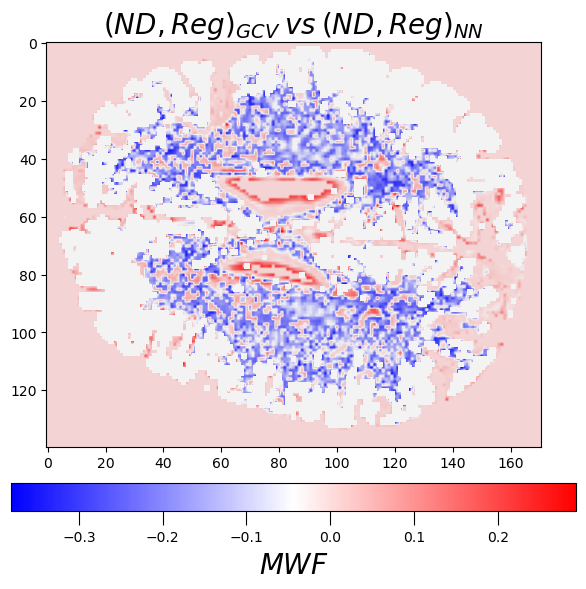

In [26]:
from matplotlib.colors import ListedColormap, Normalize
aic_mask = scipy.io.loadmat("NESMA_NLLS_results.mat")["aic_mask"] == 1.0
masked_c1_MWF = np.ma.array(c1_error_gcv, mask = aic_mask)
plot_aic = aic_mask[75:215, 56:227]
plot_masked_c1 = masked_c1_MWF[75:215, 56:227]
norm = Normalize(vmin=c1_error_gcv.min(), vmax=c1_error_gcv.max(), clip=False)
fig = plt.figure(figsize=(9,6), tight_layout = False)
c1_plot = fig.add_subplot(1,1,1)
im_c1 = c1_plot.imshow(plot_masked_c1, cmap='bwr')
im_c2 = c1_plot.imshow(plot_aic, cmap=ListedColormap(["black", "black"]), alpha=0.05)
cbar = fig.colorbar(im_c1, ax = c1_plot, location = 'bottom', pad = 0.07, shrink=0.65)
cbar.set_label(label = "$MWF$", size = 20, labelpad = 5)
cbar.ax.tick_params(size=10, labelsize=10)
c1_plot.tick_params(axis='both', which='major', labelsize=10)
c1_plot.set_title("$(ND, Reg)_{GCV} \: vs \: (ND, Reg)_{NN}$", size=20)